#BASIC IMPORTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models
from torch import optim
import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image
from io import open
import os,string,random
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
import pickle

#DATA PREPROCESSING

Data Augmentation
1. Image Resizing
2. Image Flipping
3. Add noise
4. Blur img
5. Normalization

In [3]:
class PlantImageDataloader(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        try:
            for image_folder in os.listdir(filename):                   #iterate through the different folders
                plant_name = self.getPlantName(image_folder)            #get the plant name from the function
                disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
                folders_path = f"{filename}/{image_folder}"             
                images_list = []
                labels_list=[]
                print("[INFO] Reading the folder",image_folder)         
                i=0
                for image_name in os.listdir(f"{filename}/{image_folder}"):     #iterate through the images
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                       #read image in PIL format

                    current_image = img_transform(current_image)                #transform the image (resize,flip,tensor,normalize)

                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%100==0:
                        print("Read ",i," images in ",image_folder,"folder")        
                    
                if plant_name not in dataset_dict.keys():
                    dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                    labels_dict[plant_name] = labels_list
                else:
                    dataset_dict[plant_name].extend(images_list)
                    labels_dict[plant_name].extend(labels_list)

        except Exception as e:
            print(f"Error : {e}")

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('_')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        sec_last_pos = name[:name.rfind("_")].rfind("_")        #gets the second last position of _
        tempname = name[sec_last_pos:]                          #get the disease name from the end
        disname = ""
        for sub in tempname.split('_'):                         #processing
            disname+= (sub.upper()+" ")
        disname = disname.strip()
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []

        if end>=self.n[plant_name]:
            batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
            end = self.n[plant_name]
        return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO"):
        """Funtion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0
        return img_batch,label_batch          
    


1. The image is resize to make it fit to be an input to the resnet model
2. The data is normalized in the transforms so that all the images have the same distribution in the pixels and hence the model converges faster


In [4]:
image_transform = transforms.Compose([
                    transforms.Resize(224),
                    #transforms.RandomHorizontalFlip(p=0.6),     #can be omitted
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform)

[INFO] Reading the folder Tomato_Septoria_leaf_spot
Read  100  images in  Tomato_Septoria_leaf_spot folder
Read  200  images in  Tomato_Septoria_leaf_spot folder
Read  300  images in  Tomato_Septoria_leaf_spot folder
Read  400  images in  Tomato_Septoria_leaf_spot folder
Read  500  images in  Tomato_Septoria_leaf_spot folder
Read  600  images in  Tomato_Septoria_leaf_spot folder
Read  700  images in  Tomato_Septoria_leaf_spot folder
Read  800  images in  Tomato_Septoria_leaf_spot folder
Read  900  images in  Tomato_Septoria_leaf_spot folder
Read  1000  images in  Tomato_Septoria_leaf_spot folder
Read  1100  images in  Tomato_Septoria_leaf_spot folder
Read  1200  images in  Tomato_Septoria_leaf_spot folder
Read  1300  images in  Tomato_Septoria_leaf_spot folder
Read  1400  images in  Tomato_Septoria_leaf_spot folder
Read  1500  images in  Tomato_Septoria_leaf_spot folder
Read  1600  images in  Tomato_Septoria_leaf_spot folder
Read  1700  images in  Tomato_Septoria_leaf_spot folder
[INFO

In [ ]:
image_file = open("images_dict1.pkl","wb")
label_file = open("labels_dict1.pkl","wb")
pickle.dump(train_data.images_dict,image_file)
pickle.dump(train_data.labels_dict,label_file)
image_file.close()
label_file.close()

In [5]:
path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
#path_load = f"Users/Arnav Ahuja/Desktop"
image_dict_file= open(f"{path_load}/images_dict1.pkl","rb")
label_dict_file= open(f"{path_load}/labels_dict1.pkl","rb")
image_dict_saved = pickle.load(image_dict_file)
label_dict_saved = pickle.load(label_dict_file)

In [8]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
obj_data = PlantImageDataloader(path,image_transform,image_dict_saved,label_dict_saved)

One Hot Vectors for data

In [ ]:
# li = ['a','b','c','a','e','g']
# li = np.array(li)
# li.shape

(6,)

In [ ]:
# enc = OneHotEncoder()
# li_OH = enc.fit_transform(np.expand_dims(li,1)).toarray()
# print(li_OH)

#DATA VISUALIZATION

In [10]:
def print_image(img_tensor,title="default",ax=plt,axis="off"):
    img_numpy = img_tensor.numpy()                  #convert the tensor back to nummpy array
    img_numpy = img_numpy*0.5 + 0.5                 #un-normalize the array
    img_numpy = np.transpose(img_numpy,(1,2,0))     #(channels,height,width)->(height,width,channels)
    ax.imshow(img_numpy)
    if ax==plt:
        ax.title(title,fontsize=20,va='top')
    else:
        ax.set_title(title,fontsize=5,va='top')
    ax.axis(axis)

def show_batch_img(images,labels,num_cols=4):
    n = len(images)                             #get the total number images
    num_rows = np.ceil(n/num_cols)              #get the number of rows based on the number of images in 1 row
    fig = plt.figure(figsize=(num_cols,num_rows),dpi=200)   #get a figure handler for the plot figure

    for i in range(n):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)        #add the figures 
        print_image(images[i],labels[i],ax=ax1)             #print the figures
    

In [ ]:
a,b = train_data.get_batch(5,"PEPPER")

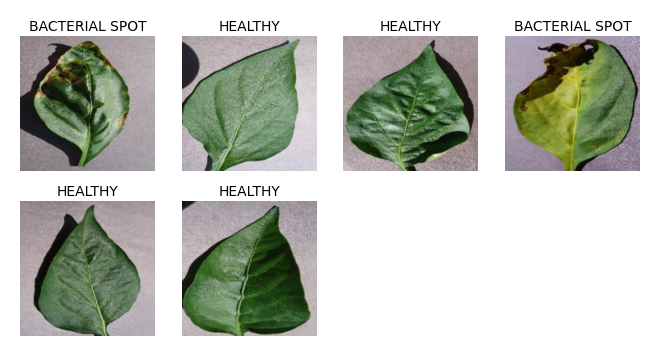

In [12]:
a,b = obj_data.get_batch(6,"PEPPER")
show_batch_img(a,b)

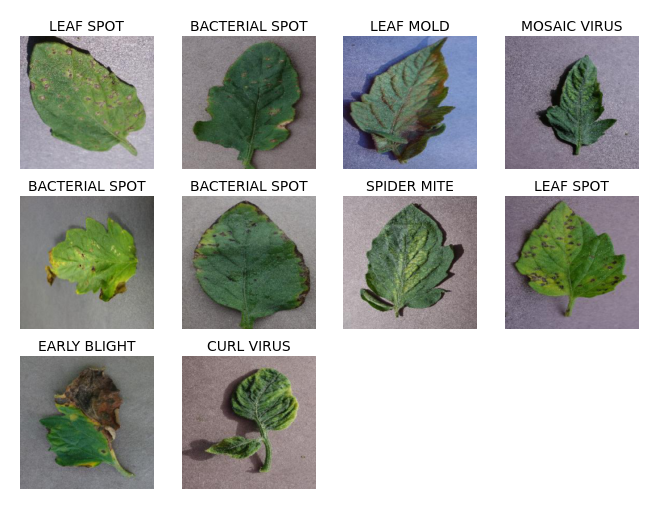

In [11]:
a,b = obj_data.get_batch(10,"TOMATO")
show_batch_img(a,b)